# Question 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

## How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

## Answer 1: Overview of the Procedure (from example)

It is largely an optimization problem where the controls are given (by the odometry $\mathbf{u}$), the model of state transition is given (as a function $f$) and the states $\mathbf{x}$ have to be found.

**Minimization Function**: Mahalanobis Distance (or _maximizing likelihood_)

$$\mathbf{L} = \underset{\textit{Odometry Constraints}}{\underbrace{\sum_{i }\lVert{f(x_{i},u_{i})-x_{i+1}}\rVert_{\sum_{i}}^2}}  + \underset{\textit{Loop Closure Constraints}}{\underbrace{\sum_{ij}\lVert{f(x_{i},u_{ij})-x_{j}}\rVert_{\Lambda_{ij}}^2}} $$

$$ \mathbf{x'} = \underset{X}{argmin}\medspace \mathbf{L} $$

Where $\left\|\cdot\right\|_{\mathbf{\Sigma}_{i}}^{2}$ is the squared [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) (which takes variance into account).

$$\left\|\mathbf{x}_{i}-\mathbf{y}_{i}\right\|_{\mathbf{\Sigma}_{i}}^{2}=\left(\mathbf{x}_{i}-\mathbf{y}_{i}\right)^{\top} \mathbf{\Sigma}_{i}^{-1}\left(\mathbf{x}_{i}-\mathbf{y}_{i}\right)$$

Coincidentally, minimizing the above function $\mathbf{L}$ is the same as maximizing the likelihood of getting the particular $\mathbf{x}$ (state) assuming an underlying multivariate gaussian distribution (note that the exponential term has $\mathbf{\Sigma}_{i}^{-1}$ in the numerator too, which is the Mahalanobis distance). In practice, we can concatenate the `odometry constraints` and `loop closure constraints` (and merge the covariance matrices) as one.

**Minimizing Method**: Gauss Newton method

The derivation (considering the Euclidean distance instead of Mahalanobis distance) is present in `Assignment 3` submission. We simply replace $\mathbf{J}^\top$ with $\mathbf{J}^\top \cdot \mathbf{\Sigma}^{-1}$ (note that the $\mathbf{J}$ associated with $\delta \mathbf{x}$ will remain as it is due to the Taylor expansion). The step is given by

$$ \delta \mathbf{x} = - \left ( \mathbf{J^\top \cdot \Sigma^{-1} \cdot J} \right )^{-1} \; \cdot \;  \mathbf{J^\top \cdot \Sigma^{-1} \cdot v} $$

Where $\mathbf{v}$ is the vector $(\mathbf{x}_{i}-\mathbf{y}_{i})$ (formed by constraints), whose Mahalanobis distance is being considered above. After calculating the above step, we simply do $\mathbf{x} \leftarrow \mathbf{x} + \delta \mathbf{x}$ to update $\mathbf{x}$ (state). Then, the vector $\mathbf{v}$ is updated and the cycle continues.

## Answer 2: Generate data

The same provided example is programmatically solved


**Controls** or Odometry

Note that the last element indicates `loop closure` (the return to a previously known spot).

This is basically

$$ \mathbf{u} = [\mathbf{u}_0, \mathbf{u}_1, \mathbf{u}_2, \mathbf{u}_3, \mathbf{u}_{(0,4)}] $$

In [2]:
# Ground truth controls (odometry)
u_gt = [1.0, 1.0, 1.0, -3.0, 0.0]   # Don't have this in real!
u_gt = np.array(u_gt)
u_mea = [1.1, 1.0, 1.1, -2.7, 0.0]  # Measurements through sensors
u_mea = np.array(u_mea)

In [3]:
# State control model: Motion model
def motion_model(u, x_p):
    """
    Returns the next state 'x' given the control input 'u' and present
    (to become previous) state 'x_p'
    
    Parameters:
    - u: float      The control input
    - x_p: float    The present (to-become-previous) state

    Returns:
    - x: float      The next state
    """
    return u + x_p


In [4]:
# Get the states
x_0_gt, x_0_odom = [0.0, 0.0]   # Starting state
x_gt = [x_0_gt]
x_odom = [x_0_odom]
for ugt, umea in zip(u_gt, u_mea):  # Find next states
    x_gt.append(motion_model(ugt, x_gt[-1]))
    x_odom.append(motion_model(umea, x_odom[-1]))
# We know the loop closure (in the end), so remove it from 'x'
x_gt = x_gt[:-1]
x_odom = x_odom[:-1]
x_gt = np.array(x_gt)
x_odom = np.array(x_odom)
print(f"Ground truth states, x_gt = {x_gt}")
print(f"Odometry states, x_odom = {x_odom}")

Ground truth states, x_gt = [0. 1. 2. 3. 0.]
Odometry states, x_odom = [0.  1.1 2.1 3.2 0.5]


As with odometry, we won't have any ground truth values in reality.

In [5]:
# Noise parameters (as variance values), more value = uncertain
var_odom = 0.01         # Variance for motion model
var_lc = 0.01           # Variance for loop closure condition
var_start_0 = 0.001     # We're sure of start at 0
num_odom, num_lc = 4, 1
var_vect = [var_odom] * num_odom + [var_lc] * num_lc + [var_start_0]
var_vect = np.array(var_vect)
var_mat = np.diag(var_vect) # Variance matrix
print(f"Variance matrix: \n{var_mat}")
# Confidence matrix (invert diagonal elements as it's a diagonal mat.)
conf_mat = np.diag(1/var_vect)
print(f"Confidence Matrix: \n{conf_mat}")

Variance matrix: 
[[0.01  0.    0.    0.    0.    0.   ]
 [0.    0.01  0.    0.    0.    0.   ]
 [0.    0.    0.01  0.    0.    0.   ]
 [0.    0.    0.    0.01  0.    0.   ]
 [0.    0.    0.    0.    0.01  0.   ]
 [0.    0.    0.    0.    0.    0.001]]
Confidence Matrix: 
[[ 100.    0.    0.    0.    0.    0.]
 [   0.  100.    0.    0.    0.    0.]
 [   0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.  100.    0.    0.]
 [   0.    0.    0.    0.  100.    0.]
 [   0.    0.    0.    0.    0. 1000.]]


## Answer 3: Optimization Function and Derivatives

The function and its Jacobian are presented in this section


Let $f$ be the `motion_model` function of the system. The constraints that have to be minimized are vectorized as follows

$$
\mathbf{v} = \mathbf{h}(\mathbf{x}) = \begin{pmatrix}
f(\mathbf{u}_0, \mathbf{x}_0) - \mathbf{x}_1 \\
f(\mathbf{u}_1, \mathbf{x}_1) - \mathbf{x}_2 \\
f(\mathbf{u}_2, \mathbf{x}_2) - \mathbf{x}_3 \\
f(\mathbf{u}_3, \mathbf{x}_3) - \mathbf{x}_4 \\
f(\mathbf{u}_{(0, 4)}, \mathbf{x}_0) - \mathbf{x}_4 \\
\mathbf{x}_0 - 0
\end{pmatrix} = \begin{pmatrix}
\mathbf{u}_0 + \mathbf{x}_0 - \mathbf{x}_1 \\
\mathbf{u}_1 + \mathbf{x}_1 - \mathbf{x}_2 \\
\mathbf{u}_2 + \mathbf{x}_2 - \mathbf{x}_3 \\
\mathbf{u}_3 + \mathbf{x}_3 - \mathbf{x}_4 \\
\mathbf{u}_{(0, 4)} + \mathbf{x}_0 - \mathbf{x}_4 \\
\mathbf{x}_0 - 0
\end{pmatrix}
$$

Note that the first four rows of $\mathbf{v}$ are odometry constraints, the fifth row is the loop closure constraint and the last row is the constraint to anchor the starting point / state to zero. The `var_matrix` is the variance matrix $\mathbf{\Sigma}$. Its inverse, the "confidence matrix" is given by `conf_mat` or $\mathbf{\Sigma}^{-1} = \mathbf{\Omega}$.

We need to find the best $\mathbf{x}$ values that minimizes the Mahalanobis distance of $\mathbf{v}$ (which we'll call deviation vector)

In [6]:
def h_x(xvals, uvals):
    """
    Returns the vector of all constraints. Described as h(x) = v above
    Needs function `motion_model`

    Parameters:
    - xvals = [x0, x1, x2, x3, x4]: State values
    - uvals = [u0, u1, u2, u3, u04]: Odometry and loop closure

    Returns:
    - v: Vector of constraints
    """
    x0, x1, x2, x3, x4 = map(float, xvals)
    u0, u1, u2, u3, u04 = map(float, uvals)
    v = np.array([
        motion_model(u0, x0) - x1,
        motion_model(u1, x1) - x2,
        motion_model(u2, x2) - x3,
        motion_model(u3, x3) - x4,
        motion_model(u04, x0) - x4,
        x0 - 0
    ])
    return v


In [7]:
v_init = h_x(x_odom, u_mea)
print(f"Initial deviation vector: {v_init}")

Initial deviation vector: [ 0.   0.   0.   0.  -0.5  0. ]


## Answer 4: Update using iterations

The Jacobian and Gauss-Newton updates are described here


The Jacobian of the above function $\mathbf{h}$ is given by

$$
\mathbf{J} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}} = \left [ 
\frac{\partial \mathbf{h}}{\partial \mathbf{x}_0} \;
\frac{\partial \mathbf{h}}{\partial \mathbf{x}_1} \cdots
\frac{\partial \mathbf{h}}{\partial \mathbf{x}_4}
\right ] = \begin{pmatrix}
1 & -1 &  0 &  0 &  0 \\
0 &  1 & -1 &  0 &  0 \\
0 &  0 &  1 & -1 &  0 \\
0 &  0 &  0 &  1 & -1 \\
1 &  0 &  0 &  0 & -1 \\
1 &  0 &  0 &  0 &  0
\end{pmatrix}
$$

This is the jacobian used for all updates in 

$$ \delta \mathbf{x} = - \left ( \mathbf{J^\top \cdot \Omega \cdot J} \right )^{-1} \; \cdot \;  \mathbf{J^\top \cdot \Omega^\top \cdot v} $$

Fortunately for us, the part $\mathbf{K} = - \left ( \mathbf{J^\top \cdot \Omega \cdot J} \right )^{-1} \; \cdot \;  \mathbf{J^\top \cdot \Omega^\top}$ is a constant (it doesn't depend on $\mathbf{x}$ or $\mathbf{u}$). So we compute it early-hand and use it repeatedly. Let $\mathbf{G} = \mathbf{J^\top \cdot \Omega \cdot J}$.

Almost everywhere $\mathbf{\Omega}^\top = \mathbf{\Omega}$ holds good.

In [8]:
# Declare jacobian in code
jac = np.array([
    [1, -1, 0, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [0, 0, 0, 1, -1],
    [1, 0, 0, 0, -1],
    [1, 0, 0, 0, 0]
])
print(f"Jacobian is: \n{jac}")
jac_t_conf_jac = jac.T @ conf_mat @ jac
K = -np.linalg.inv(jac_t_conf_jac) @ jac.T @ conf_mat
print(f"G = \n{jac_t_conf_jac}")

Jacobian is: 
[[ 1 -1  0  0  0]
 [ 0  1 -1  0  0]
 [ 0  0  1 -1  0]
 [ 0  0  0  1 -1]
 [ 1  0  0  0 -1]
 [ 1  0  0  0  0]]
G = 
[[1200. -100.    0.    0. -100.]
 [-100.  200. -100.    0.    0.]
 [   0. -100.  200. -100.    0.]
 [   0.    0. -100.  200. -100.]
 [-100.    0.    0. -100.  200.]]


In [9]:
# Initialize everything
num_iter = 10   # Number of iterations
x_vect = np.array(x_odom).reshape(-1, 1)
u_vect = np.array(u_mea).reshape(-1, 1)
# Logs
cost_hist = []  # History of Mahalanobis Costs
v_hist = []     # History of 'v' vector

In [10]:
# Gauss Newton updates
for _ in range(num_iter):
    # Calculate cost
    v = h_x(x_vect, u_vect).reshape(-1, 1)
    v_hist.append(v.flatten())
    mls_cost = float(v.T @ conf_mat @ v)
    cost_hist.append(mls_cost)  # Log cost
    # Updates
    del_x = K @ v
    x_vect = x_vect + del_x


Final states: [0.  1.  1.9 2.9 0.1]


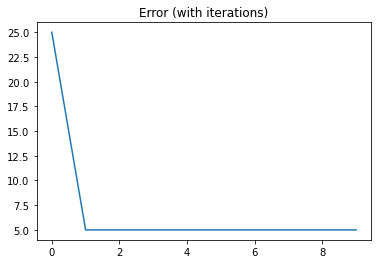

In [16]:
x_final = x_vect.flatten()
print(f"Final states: {x_final}")
plt.title("Error (with iterations)")
plt.plot(cost_hist)

## Plot the result

Plot everything


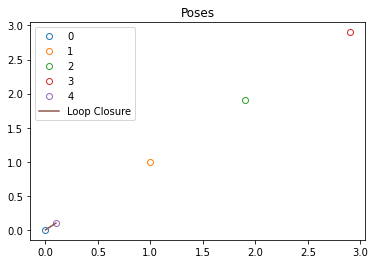

In [21]:
# Plot everything
plt.title("Poses")
plt.plot(x_final[0], x_final[0], 'o', fillstyle='none', label="0")
plt.plot(x_final[1], x_final[1], 'o', fillstyle='none', label="1")
plt.plot(x_final[2], x_final[2], 'o', fillstyle='none', label="2")
plt.plot(x_final[3], x_final[3], 'o', fillstyle='none', label="3")
plt.plot(x_final[4], x_final[4], 'o', fillstyle='none', label="4")
plt.plot([x_final[0], x_final[4]], [x_final[0], x_final[4]], 
    label="Loop Closure")
plt.legend()